In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision

from matplotlib import pyplot as plt
import numpy as np

print(torch.__version__)

2.0.0


In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Download training data from open datasets.
training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)


# Download test data from open datasets.
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)


In [4]:
print(training_data.data.size())
print(test_data.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [5]:
# from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]



Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


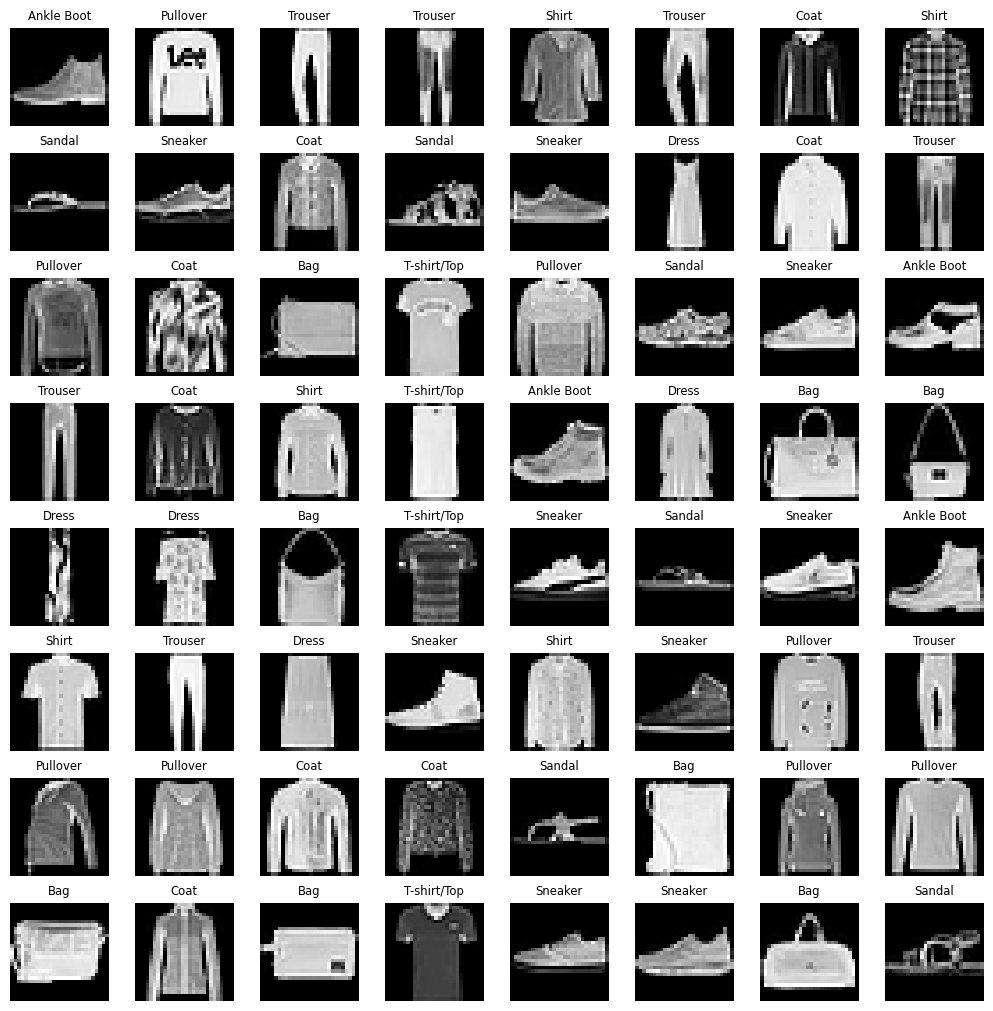

In [6]:
def plot_first_samples(dataloader):
    rows = 8
    columns = 8
    fig = plt.figure(figsize=(10, 10), layout="constrained")
    for X, y in dataloader:
        for i, (image, label) in enumerate(zip(X, y)):
            fig.add_subplot(rows, columns, i+1)
            plt.axis('off')
            plt.title(output_label(label.item()), size="small")
            plt.imshow(image[0].detach().numpy(), cmap='gray')
        break

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

plot_first_samples(test_dataloader)
plt.show()


In [ ]:
# Feed Forward Neural Network

# model architecture from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

class Classifier(nn.Module):
    def __init__(self, input_shape : torch.Size, hidden_sizes : list[int], num_classes : int, activation_function, loss_fn):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential( # todo use hidden sizes
            nn.Linear(64*6*6, 600),
            nn.Dropout(0.25),
            activation_function,
            nn.Linear(600, 120),
            activation_function,
            nn.Linear(120, num_classes) # no softmax necessary
        )

        self.num_classes = num_classes
        self.loss_fn = loss_fn

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


    def train_network(self, dataloader : DataLoader, optimizer : torch.optim.Optimizer):
        size = len(dataloader.dataset)
        self.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            y_pred = self.forward(X)
            loss = self.loss_fn(y_pred, F.one_hot(y, self.num_classes).type(y_pred.dtype))

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def test(self, dataloader : DataLoader):
        num_batches = len(dataloader)
        self.eval()
        test_loss = 0
        num_right = 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                y_pred  = self.forward(X)
                test_loss += self.loss_fn(y_pred , F.one_hot(y, self.num_classes).type(y_pred.dtype)).item()
                num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
        test_loss /= num_batches
        accuracy = num_correct / len(dataloader.dataset)
        print(f"Test Error: Avg loss: {test_loss:>8f} Accuracy: {accuracy:>8f} \n")

In [ ]:
# Train Classifier (SGD)
size = torch.Size((1,28,28))
num_classes = 10
epochs = 1

classifiers_sgd : dict[str, Classifier] = {}
for activation_function in [nn.Identity(), nn.Sigmoid(), nn.ReLU(), nn.SELU(), nn.ELU(), nn.LeakyReLU(), nn.SiLU()]:
    classifier = Classifier(size, [], num_classes, activation_function, nn.CrossEntropyLoss()).to(device)
    optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-3)
    print(str(activation_function))

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        classifier.train_network(train_dataloader, optimizer)
        classifier.test(test_dataloader)
    print("Done!")

    classifiers_sgd[str(activation_function)] = classifier

loss: 1.198086  [12864/60000]
loss: 1.185318  [19264/60000]


KeyboardInterrupt: 

In [9]:
for name, classifier in classifiers_sgd.items():
    print(f"Name: {name}")
    classifier.test(test_dataloader)

Name: Identity()
Test Error: Avg loss: 0.721526 Accuracy: 0.000000 

Name: Sigmoid()
Test Error: Avg loss: 2.301502 Accuracy: 0.000000 

Name: ReLU()
Test Error: Avg loss: 0.993249 Accuracy: 0.000000 

Name: SELU()
Test Error: Avg loss: 0.644016 Accuracy: 0.000000 

Name: ELU(alpha=1.0)
Test Error: Avg loss: 0.820657 Accuracy: 0.000000 

Name: LeakyReLU(negative_slope=0.01)
Test Error: Avg loss: 1.066016 Accuracy: 0.000000 

Name: SiLU()
Test Error: Avg loss: 1.418232 Accuracy: 0.000000 



Identity()


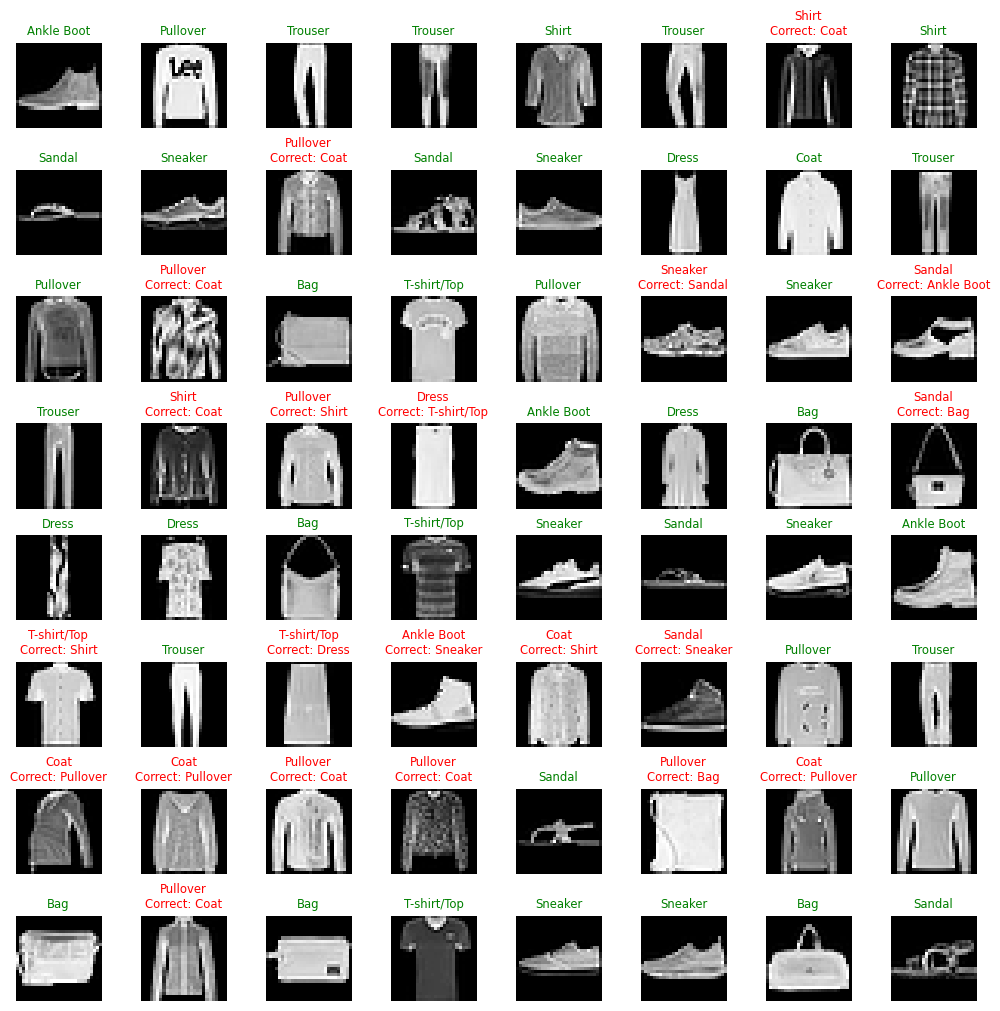

Sigmoid()


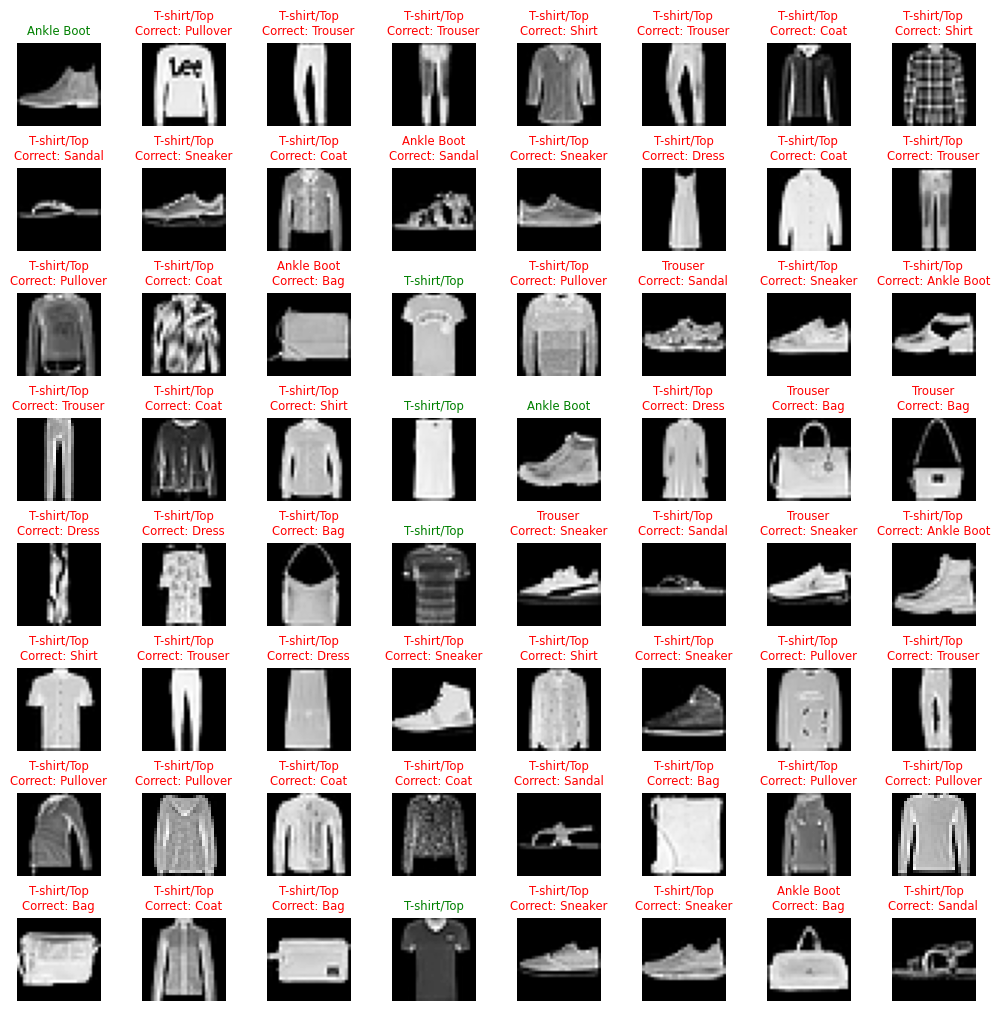

ReLU()


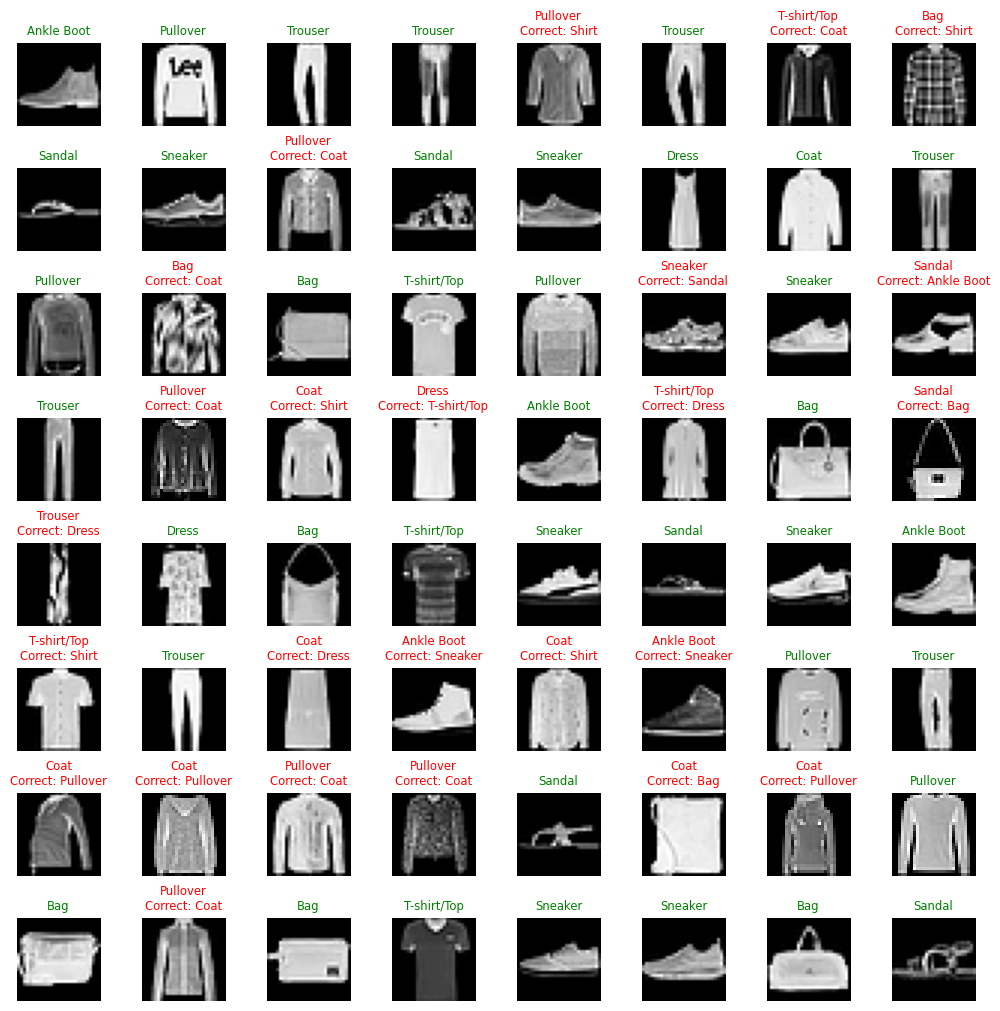

SELU()


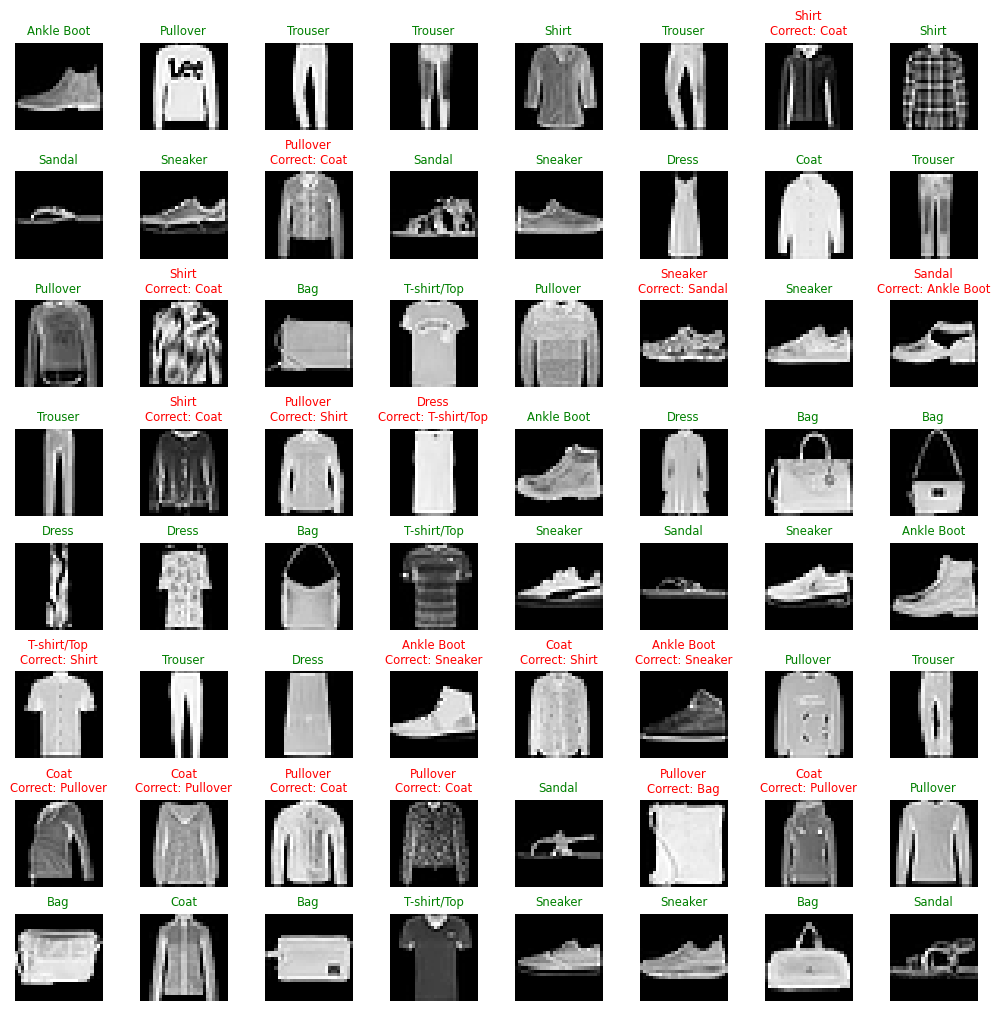

ELU(alpha=1.0)


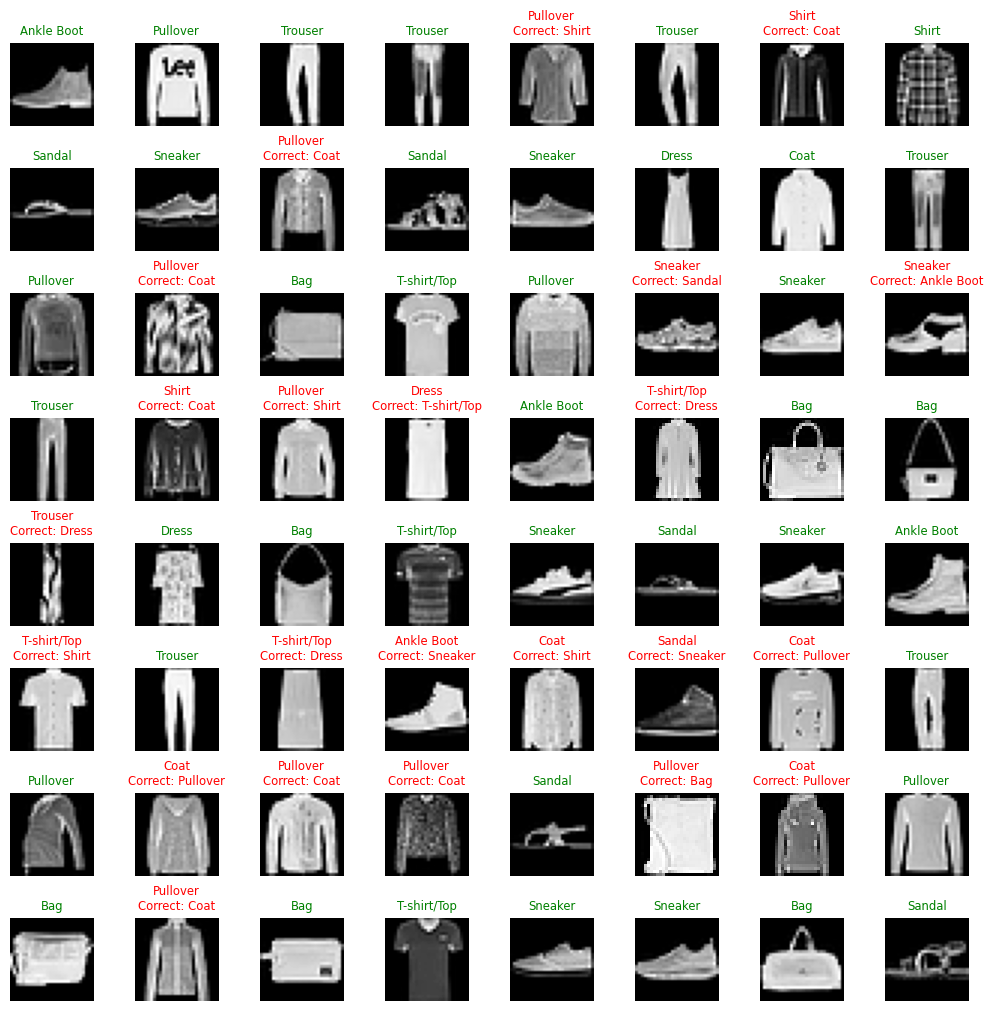

LeakyReLU(negative_slope=0.01)


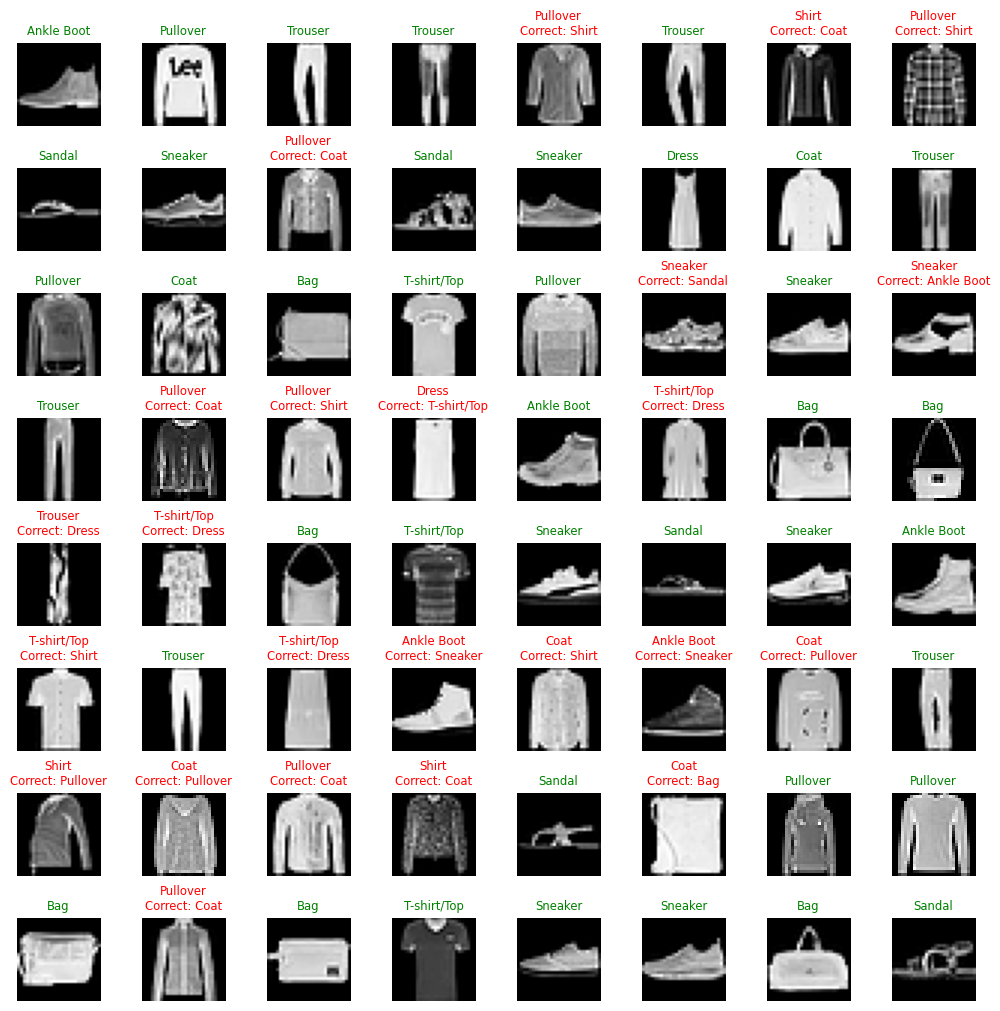

SiLU()


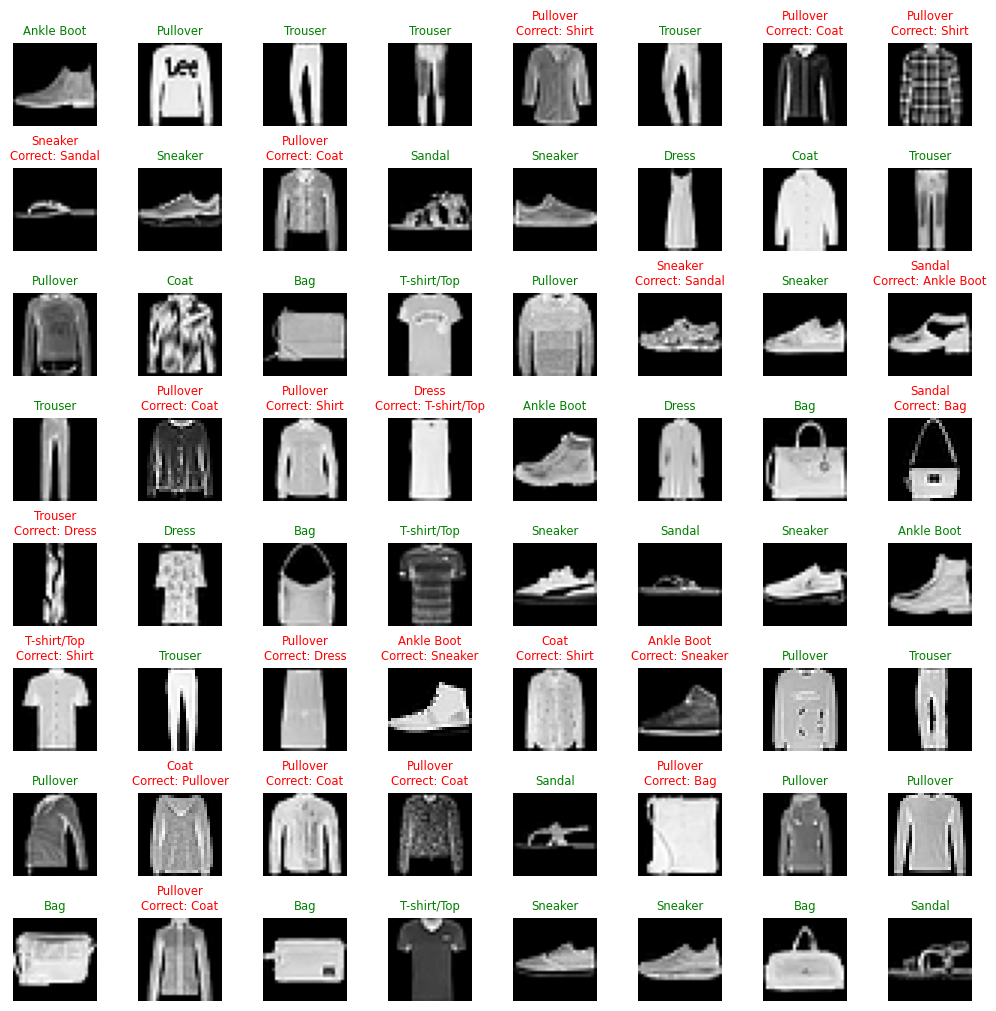

In [10]:
def plot_classified_first_samples(dataloader, model):
    rows = 8
    columns = 8
    fig = plt.figure(figsize=(10, 10), layout="constrained")
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = torch.argmax(model.forward(X.to(device)), dim=1).to('cpu')
            for i, (image, true_label, predicted_label) in enumerate(zip(X, y, y_pred)):
                fig.add_subplot(rows, columns, i+1)
                plt.axis('off')
                plt.title(output_label(predicted_label.item()) + ("\nCorrect: " + output_label(true_label) if predicted_label != true_label else ""),
                          color="green" if predicted_label == true_label else "red",
                          size="small")
                plt.imshow(image[0].detach().numpy(), cmap='gray')
            break

for name, classifier in classifiers_sgd.items():
    print(name)
    plot_classified_first_samples(test_dataloader, classifier)
    plt.show()

In [11]:
def print_accuracy_per_class(dataloader, models):

    # max_label_length = max(len(output_label(i)) for i in range(num_classes))
    # print(max_label_length)
    # max_model_name_length = max(len(name) for name in models.keys())
    # print(max_model_name_length)

    print(f'{"":<31s}', end = "")
    for i in range(num_classes):
        print(f'{output_label(i):<12s}', end = "")
    print(f'{"All":<12s}')

    for name, model in models.items():
        print(f'{name:<31s}', end = "")

        num_correct = np.zeros(num_classes)
        totals = np.zeros(num_classes)
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                y_pred  = model.forward(X)
                for real, pred in zip(y.to("cpu"),torch.argmax(y_pred.to("cpu"), dim=1)):
                    totals[real.item()] += 1
                    if real == pred:
                        num_correct[real.item()] += 1
        accuracies = num_correct / totals
        for i, accuracy in enumerate(accuracies):
            print(f'{accuracy:<12f}', end = "")
        print(f'{sum(num_correct) / sum(totals):<12f}')

print_accuracy_per_class(test_dataloader, classifiers_sgd)


                               T-shirt/Top Trouser     Pullover    Dress       Coat        Sandal      Shirt       Sneaker     Bag         Ankle Boot  All         
Identity()                     0.778000    0.934000    0.677000    0.801000    0.668000    0.883000    0.226000    0.827000    0.887000    0.931000    0.761200    
Sigmoid()                      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.295000    0.129500    
ReLU()                         0.774000    0.915000    0.533000    0.747000    0.722000    0.860000    0.087000    0.811000    0.875000    0.940000    0.726400    
SELU()                         0.798000    0.941000    0.673000    0.841000    0.711000    0.882000    0.234000    0.832000    0.915000    0.939000    0.776600    
ELU(alpha=1.0)                 0.812000    0.931000    0.620000    0.807000    0.650000    0.858000    0.111000    0.832000    0.902000    0.934000    0.745700    
LeakyReLU(negati

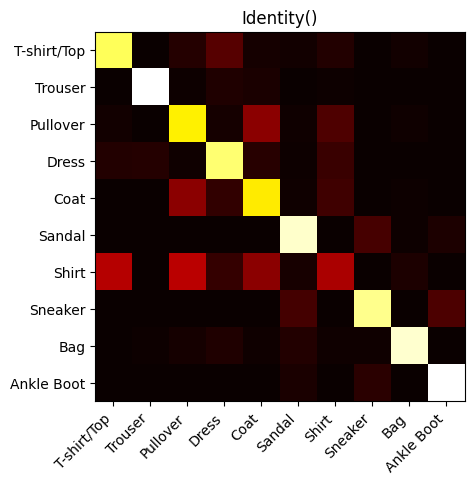

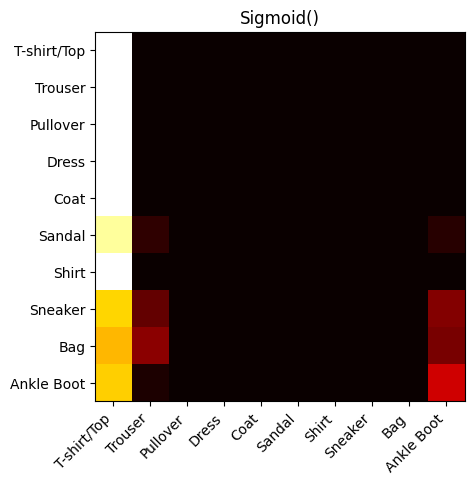

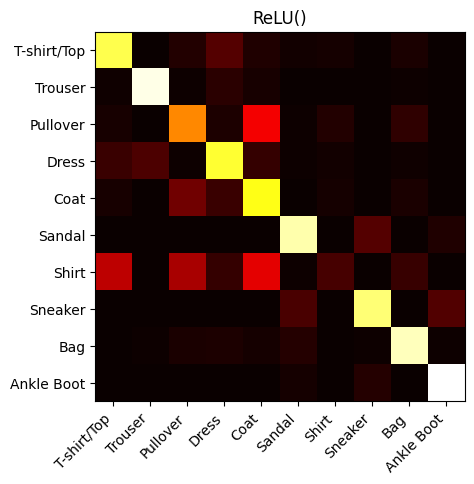

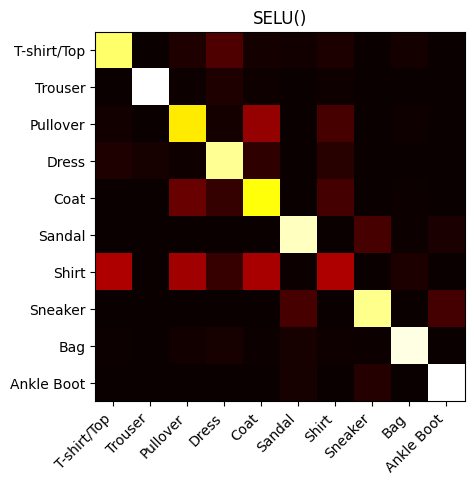

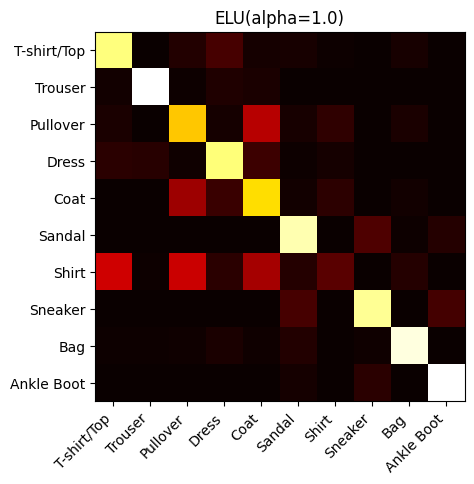

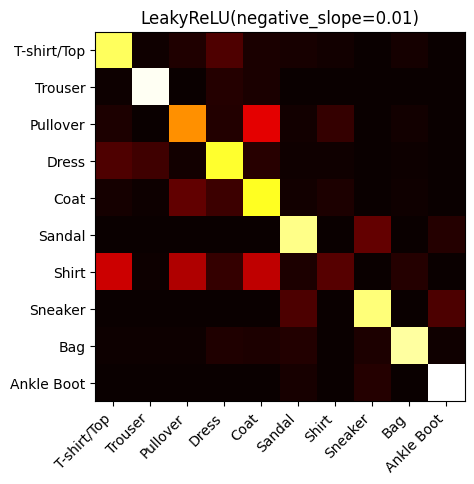

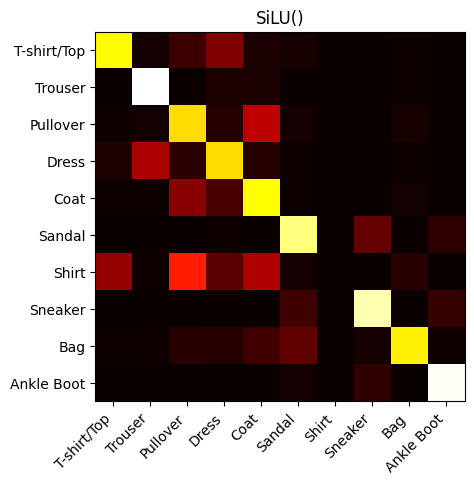

In [13]:
def print_confusion_matrix(dataloader, models):

    for name, model in models.items():
        matrix = np.zeros([num_classes, num_classes])
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                y_pred  = model.forward(X)
                for real, pred in zip(y.to("cpu"),torch.argmax(y_pred.to("cpu"), dim=1)):
                    matrix[real.item()][pred.item()] += 1
        matrix / len(dataloader.dataset)

        plt.imshow(matrix, cmap='hot')
        indices = [i for i in range(num_classes)]
        labels = [output_label(i) for i in range(num_classes)]
        plt.xticks(indices, labels, rotation=45, ha="right")
        plt.yticks(indices, labels)
        plt.title(name)
        plt.show()

print_confusion_matrix(test_dataloader, classifiers_sgd)
